# ConvCNP for Interpolating Temperature from Sensor Readings and ERA5

The first small-scale experiment to use a ConvCNP to interpolate sensor temperature readings, with topography, ERA5, and sensor layers.

In [1]:
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [2]:
%load_ext autoreload

In [61]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var
import src.learning.model_diagnostics as model_diagnostics
from src.learning.model_training import train_epoch_many_targets

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topology_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

In [ ]:
# DeepSensor imports
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch
from torch import optim
import os
import lab as B
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf

In [5]:
# setup variables for experiment
var = TEMPERATURE
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010] #[2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    set_gpu_default_device()

# visualisations of data
DEBUG_PLOTS = True

In [6]:
# load datasets
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()


In [7]:
# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)

In [8]:
# clean up the ERA5 data:
era5_da = era5_processor.get_variable(era5_ds, var) # set variable to process - e.g. "temperature"
era5_da = kelvin_to_celsius(era5_da)

### Crop data for proof-of-concept

In [9]:
crop_left = 166
crop_right = 176
crop_top = -38
crop_bottom = -48

In [10]:
era5_da = era5_da.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
topography_ds = topography_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

### Cleanup & validation of ERA5 Data

In [11]:
# coarsen ERA5
era5_da_coarsen = era5_da.coarsen(lat=2, lon=2, boundary='trim').mean()

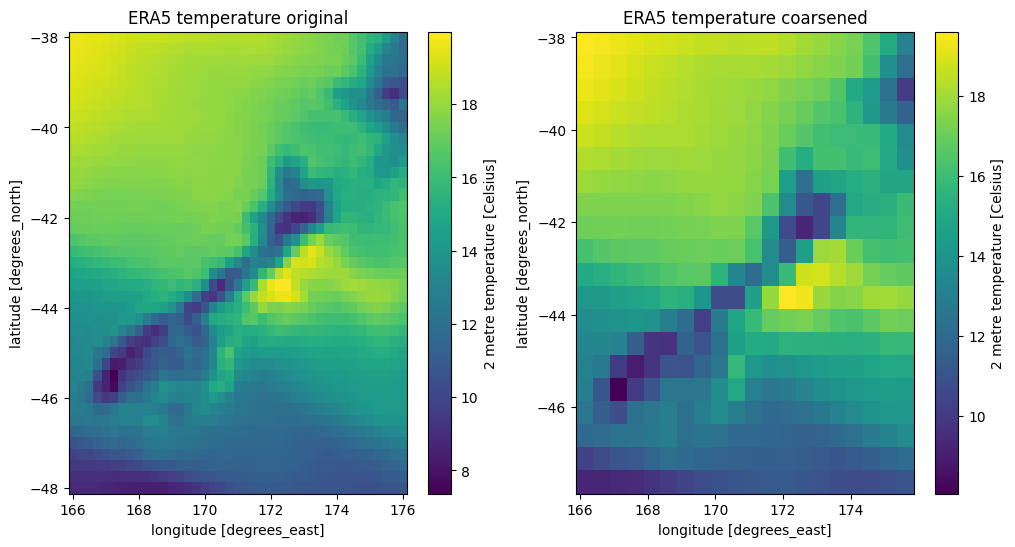

In [12]:
if DEBUG_PLOTS:
    # visual check of correctness
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    era5_da.sel(time="2010-01-01T18:00").plot(ax=ax[0])
    ax[0].set_title(f"ERA5 {var} original") 
    era5_da_coarsen.sel(time="2010-01-01T18:00").plot(ax=ax[1])
    ax[1].set_title(f"ERA5 {var} coarsened")
    plt.show()

### Cleanup & Validation of Topographical Data

In [13]:
# Compute the topographic position index (TPI) from elevation data
ds_aux = topography_processor.compute_tpi(topography_ds)

# coarsen the elevation data
#topo_coarse = topography_ds.coarsen(lat=100, lon=100, boundary='trim').mean()[ELEVATION]
ds_aux_coarse  = ds_aux.coarsen(lat=100, lon=100, boundary='trim').mean()

In [14]:
ds_aux.data_vars

Data variables:
    elevation    (lat, lon) float32 244MB nan nan nan nan ... 535.1 533.8 536.9
    tpi_ws0_1    (lat, lon) float32 244MB nan nan nan nan ... 104.3 101.6 103.5
    tpi_ws0_05   (lat, lon) float32 244MB nan nan nan nan ... 61.28 58.26 59.81
    tpi_ws0_025  (lat, lon) float32 244MB nan nan nan nan ... 34.63 31.75 33.47

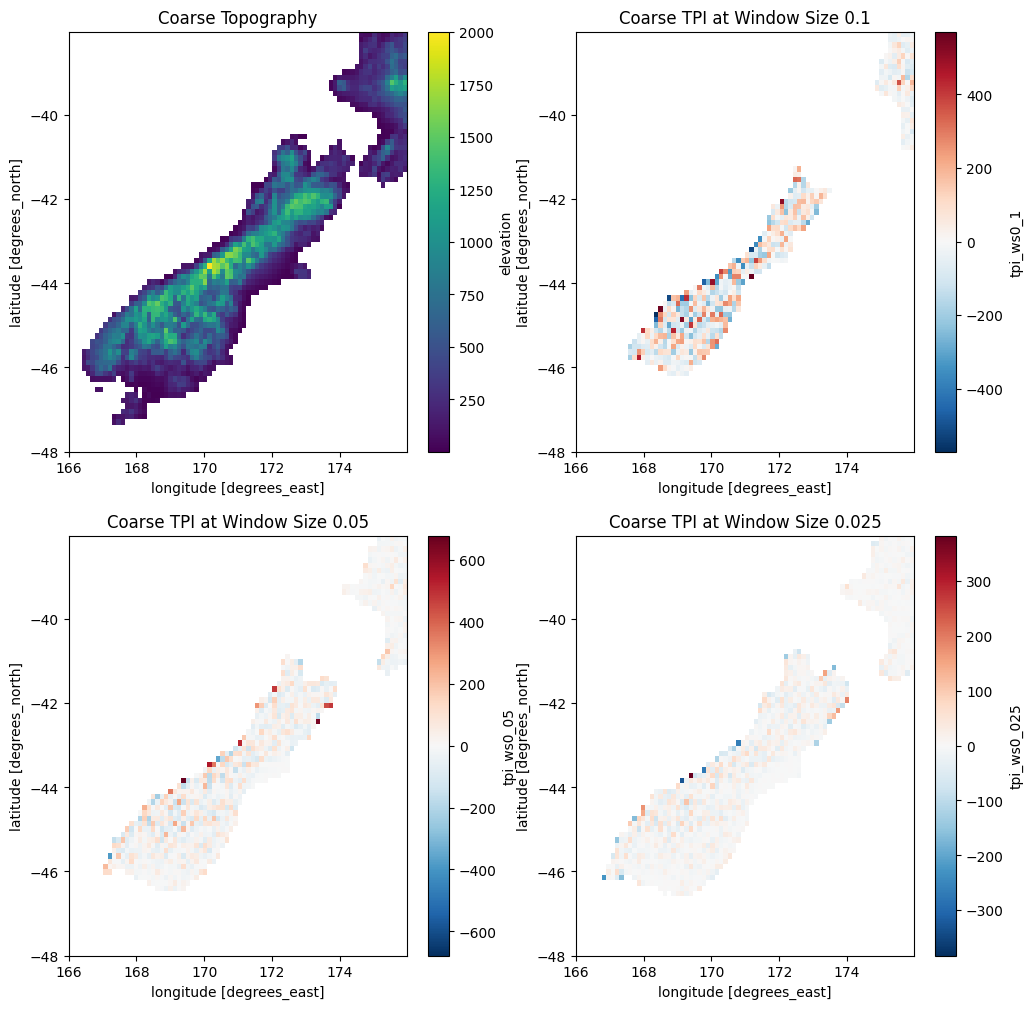

In [15]:
if DEBUG_PLOTS:
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    ds_aux_coarse[ELEVATION].plot(ax=ax[0, 0])
    ax[0, 0].set_title("Coarse Topography")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[0, 1])
    ax[0, 1].set_title("Coarse TPI at Window Size 0.1")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_05"].plot(ax=ax[1, 0])
    ax[1, 0].set_title("Coarse TPI at Window Size 0.05")
    
    ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_025"].plot(ax=ax[1, 1])
    ax[1, 1].set_title("Coarse TPI at Window Size 0.025")
    
    plt.show()

In [16]:
# fill elevation Nans with 0's (ocean areas)
ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

### Load the stations
Not all stations load temperature across all timestamps.

Desired data format:

| lat | long | time | temperature |
|:---:|:----:|:----:|:-----------:|
| float | float | timestamp | float |
| float | float | timestamp | float |

In [17]:
# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[var], year_start=2010, year_end=2014)

/home/lennoxc/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")


In [18]:
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

In [19]:
# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

/tmp/ipykernel_9164/3879327337.py:2: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]


In [20]:
# slice to smaller area for proof-of-concept
stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]


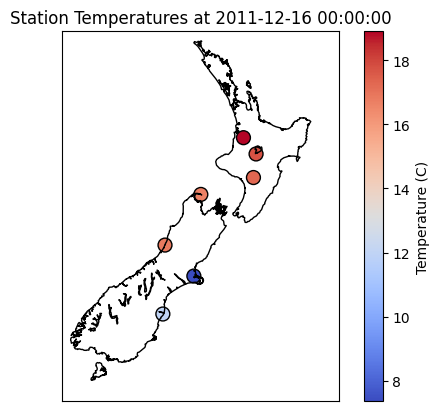

In [21]:
# plot temperature across all locations using temperature colormap at a single time step
# plot on a map of NZ using basemap
time_step = "2011-12-16 00:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

### Ensure compatibility of layers

In [22]:
# slice the ERA5 data to match the topography extent
era5_da = era5_da.sel(lat=slice(ds_aux_coarse[LATITUDE].max(), ds_aux_coarse[LATITUDE].min()), lon=slice(ds_aux_coarse[LONGITUDE].min(), ds_aux_coarse[LONGITUDE].max()))

### Normalisation and Preprocessing

In [23]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_da[LATITUDE].min(), era5_da[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_da[LONGITUDE].min(), era5_da[LONGITUDE].max()))

In [24]:
era5_processed, station_processed = data_processor([era5_da_coarsen, stations_resample])

In [25]:
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

In [26]:
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-47.75, -38.25), 'name': 'lat'},
            'x2': {'map': (166.25, 175.75), 'name': 'lon'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 3655.506591796875, 'min': -3.802651882171631}},
 'temperature': {'method': 'mean_std',
                 'params': {'mean': 12.106828689575195,
                            'std': 4.057885646820068}},
 'tpi_ws0_025': {'method': 'min_max',
                 'params': {'max': 1339.210205078125,
                            'min': -789.6385498046875}},
 'tpi_ws0_05': {'method': 'min_max',
                'params': {'max': 1790.2523193359375,
                           'min': -940.9993286132812}},
 'tpi_ws0_1': {'method': 'min_max',
               'params': {'max': 1588.9427490234375,
                          'min': -904.8171997070312}}}


In [27]:
x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

In [28]:
ds_aux_coarse_processed

<xarray.Dataset> Size: 147kB
Dimensions:      (x1: 78, x2: 78)
Coordinates:
  * x1           (x1) float32 312B -0.01965 -0.006173 0.007302 ... 1.004 1.018
  * x2           (x2) float32 312B -0.01958 -0.006104 0.007369 ... 1.004 1.018
Data variables:
    elevation    (x1, x2) float32 24kB -0.9979 -0.9979 ... -0.8936 -0.8193
    tpi_ws0_1    (x1, x2) float32 24kB -0.2743 -0.2743 ... -0.3127 -0.2917
    tpi_ws0_05   (x1, x2) float32 24kB -0.3109 -0.3109 ... -0.319 -0.3198
    tpi_ws0_025  (x1, x2) float32 24kB -0.2582 -0.2582 ... -0.2596 -0.2634
    x1_arr       (x1, x2) float32 24kB -0.01965 -0.01965 ... 1.018 1.018
    x2_arr       (x1, x2) float32 24kB -0.01958 -0.006104 ... 1.004 1.018
Attributes:
    crs:          EPSG:4326
    nodata:       nan
    institution:  Bodeker Scientific
    author:       Greg Bodeker / William Naylor
    email:        greg@bodekerscientific.com
    created:      2023-11-08 03:54:55 UTC
    script:       topo_convert_L8m.py
    conda_env:    The conda environment as at the time of committing the abov...
    script_sha:   7cc03c50847619e02211950c9204a30f4c6b205f

In [29]:
# this doesn't use any stations in the context set.
# this should be updated for data assimilation experiments later.
task_loader = TaskLoader(context=[era5_processed, ds_aux_coarse_processed], target=station_processed, aux_at_targets=ds_aux_processed)

In [30]:
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 74
encoder_scales inferred from TaskLoader: [np.float32(0.026315786), np.float32(0.0067368336)]
decoder_scale inferred from TaskLoader: 0.013513513513513514


In [31]:
task_loader.load_dask()

In [32]:
train_dates = era5_da.sel(time=slice("2010-01-01", "2011-12-31")).time.values
val_dates = era5_da.sel(time=slice("2012-01-01", "2012-06-30")).time.values

In [33]:
from tqdm import tqdm
train_tasks = []
for date in tqdm(train_dates[::2]):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    train_tasks.append(task)

val_tasks = []
for date in tqdm(val_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    val_tasks.append(task)

100%|██████████| 728/728 [00:03<00:00, 211.04it/s]


/home/lennoxc/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


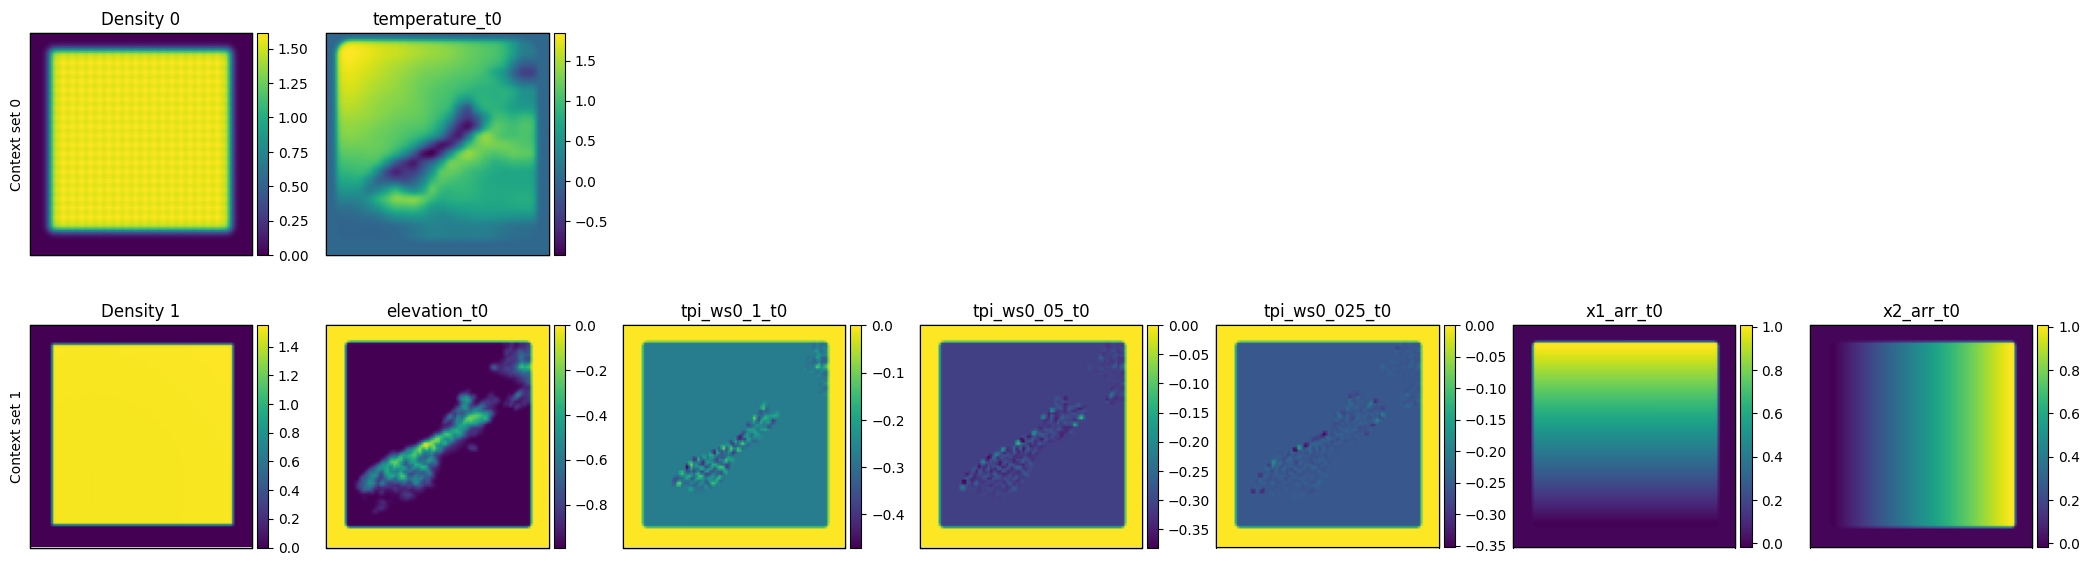

In [34]:
fig = deepsensor.plot.context_encoding(model, train_tasks[1], task_loader)

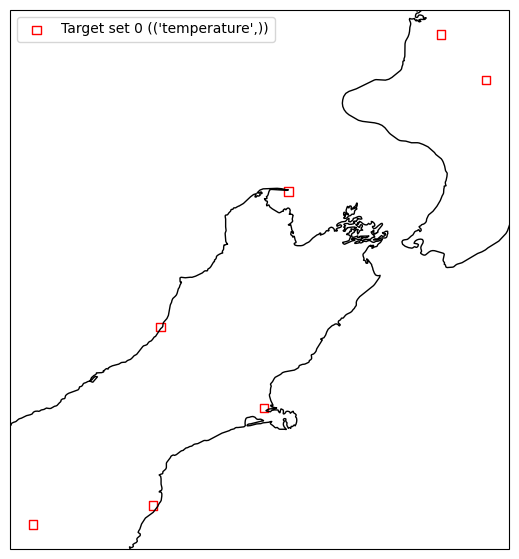

In [35]:
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': crs})
ax.coastlines()
ax.add_feature(cf.BORDERS)
deepsensor.plot.offgrid_context(ax, train_tasks[5], data_processor, task_loader, plot_target=True)
plt.show()

# Understanding the ConvNP Architecture

In [36]:
assert str(type(model)) == "<class 'deepsensor.model.convnp.ConvNP'>"
assert str(type(model.model)) == "<class 'neuralprocesses.torch.Model'>"
assert str(type(model.model.encoder)) == "<class 'neuralprocesses.torch.FunctionalCoder'>"
assert str(type(model.model.decoder)) == "<class 'neuralprocesses.torch.Chain'>"

The ConvNP class has an encoder-decoder architecture, which encodes inputs onto the internal grid, with a latent representation. The full source for a ConvGNP can be found here: https://github.com/wesselb/neuralprocesses/blob/main/neuralprocesses/architectures/convgnp.py

## Encoder:
At a high level, the encoder is of class 'neuralprocesses.torch.FunctionalCoder'. This has a `.coder` field, which contains the Chain object.

Context Encoding:
- The SetConv encoder maps the context sets (ERA5, sensors, topology) to the ConvNP's internal grid.
- Place a Gaussian kernel at each (x, y) location (in space). Weight these by the observation values (e.g. temperature).
- Place a Gaussian kernel at each (x, y) location (in space). Weight by presence of input to create a density map.

A suitible input stucture could be:
- Context set 0: Sensor obs (with their own density channel). Density will be sparse.
- Context set 1: Complete sets of weather observations (ERA5, satellite etc). Density will be full.
- Context set 2: Stationary context data (sun incedence, topography etc). Density will be full.

One density channel per context set is created.

In [37]:
for i in range(len(model.model.encoder.coder.links)):
    print(f"Link {i}: {type(model.model.encoder.coder.links[i])}")
    print(model.model.encoder.coder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.AssertParallel'>
AssertParallel()
--------------------
Link 1: <class 'neuralprocesses.torch.PrependDensityChannel'>
PrependDensityChannel()
--------------------
Link 2: <class 'neuralprocesses.torch.Parallel'>
Parallel(
    SetConv(),
    SetConv(),
)
--------------------
Link 3: <class 'neuralprocesses.torch.DivideByFirstChannel'>
DivideByFirstChannel()
--------------------
Link 4: <class 'neuralprocesses.torch.Concatenate'>
Concatenate()
--------------------
Link 5: <class 'neuralprocesses.torch.nn._LambdaModule'>
_LambdaModule()
--------------------
Link 6: <class 'neuralprocesses.torch.DeterministicLikelihood'>
DeterministicLikelihood()
--------------------


## Decoder

In [38]:
for i in range(len(model.model.decoder.links)):
    print(f"Link {i}: {type(model.model.decoder.links[i])}")
    print(model.model.decoder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.UNet'>
UNet(
  (before_turn_layers): ModuleList(
    (0): Conv2d(9, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (after_turn_layers): ModuleList(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (4): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (final_linear): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
)
--------------------
Link 1: <class 'neuralprocesses.torch.RepeatForAggregateInputs'>
RepeatForAggregateInputs(
  (coder): Chain(
      SetConv(),
      _Lamb

In [39]:
print(f"{model_diagnostics.count_model_parameters(model.model):,}")

Total number of parameters: 1367429
1,367,429


In [40]:
#find_model_structure(model.model)
model_diagnostics.model_parameters_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>): 0 parameters
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>): 0 parameters
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>): 0 parameters
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>): 1 parameters
                    Layer 1 (<class 'neuralprocesses.torch.Set

In [41]:
model_diagnostics.model_dimensions_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>):
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>):
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>):
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>):
                            Parameter: log_scale, Shape: torch.Size([])
                    Layer 1 (<class 'neura

In [42]:
deepsensor.model.nps.compute_encoding_tensor(model, train_tasks[0]).shape

(1, 9, 96, 96)

In [43]:
model.config

{'dim_x': 2,
 'dim_yc': (1, 6),
 'dim_yt': 1,
 'dim_aux_t': 4,
 'dim_lv': 0,
 'conv_arch': 'unet',
 'unet_channels': (64, 64, 64, 64, 64),
 'unet_resize_convs': True,
 'unet_resize_conv_interp_method': 'bilinear',
 'aux_t_mlp_layers': (64, 64, 64),
 'likelihood': 'lowrank',
 'unet_kernels': 5,
 'internal_density': 74,
 'encoder_scales': [np.float32(0.026315786), np.float32(0.0067368336)],
 'encoder_scales_learnable': False,
 'decoder_scale': 0.013513513513513514,
 'decoder_scale_learnable': False,
 'num_basis_functions': 64,
 'epsilon': 0.01}

### Setting up for Model Training

In [44]:
def compute_val_loss(model, val_tasks):
    val_losses = []
    for task in val_tasks:
        val_losses.append(B.to_numpy(model.loss_fn(task, normalise=True)))
    return np.mean(val_losses)

In [63]:
n_epochs = 1
train_losses = []
val_losses = []
lr=5e-5

output_model = False

val_loss_best = np.inf

opt = optim.Adam(model.model.parameters(), lr=lr)

for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch_many_targets(model, train_tasks, batch_size=1, opt=opt)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        val_loss_best = val_loss
        if output_model:
            folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "downscaling", "temperature", "convcnp")
            if not os.path.exists(folder): os.makedirs(folder)
            torch.save(model.model.state_dict(), folder + f"model.pt")

    torch.cuda.empty_cache()

    print(f"Epoch {epoch} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:54<00:00, 54.95s/it]

Epoch 0 train_loss: 5.33, val_loss: 4.83


Text(0, 0.5, 'Loss')

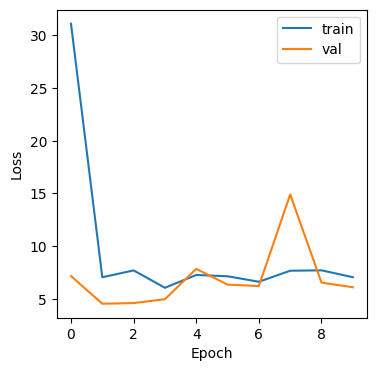

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

The model can train itself - but we are currently not providing useful inputs, and it is therefore overfitting.

Gradient descent will be very unstable as the batch size equals 1.

Memory only sits at 242MiB while training. It seems that memory spikes while loading a large amount of data. I wonder if there is just one bit of the process that needs to be optimised in order to prevent OOM errors?